In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

housing = pd.read_csv("housing.csv")

In [2]:
# this creates a testset for us from the dataset we use 20% here
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [3]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [4]:
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    
    return data.loc[~in_test_set], data.loc[in_test_set]

In [5]:
# to make sure that the test set is the same every time we run the program we can check the row index as id
housing_with_id = housing.reset_index() # adds an index column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [6]:
# latatude and longiude are stable for each district so we can use them as id
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [7]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [8]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

Text(0, 0.5, 'Number of Districts')

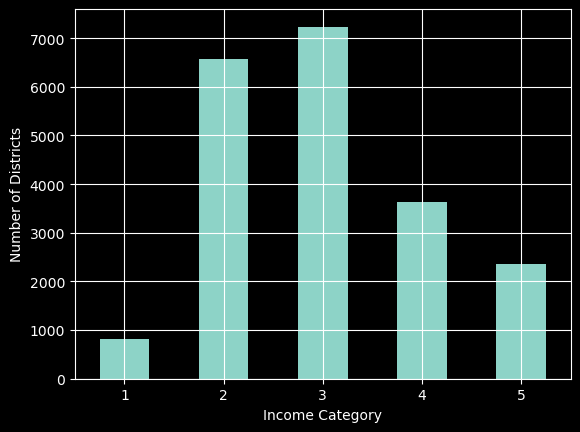

In [9]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")

In [10]:
# this generates 10 different stratified splits of the dataset into training and test sets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append((strat_train_set_n, strat_test_set_n))

strat_train_set, strat_test_set = strat_splits[0]
# this is a shorter way to get a single stratified split
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42
)

In [11]:
# we can now remove the income_cat attribute so the data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [12]:
# we want to make a copy so we can revert back to in case we mess up the training set
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

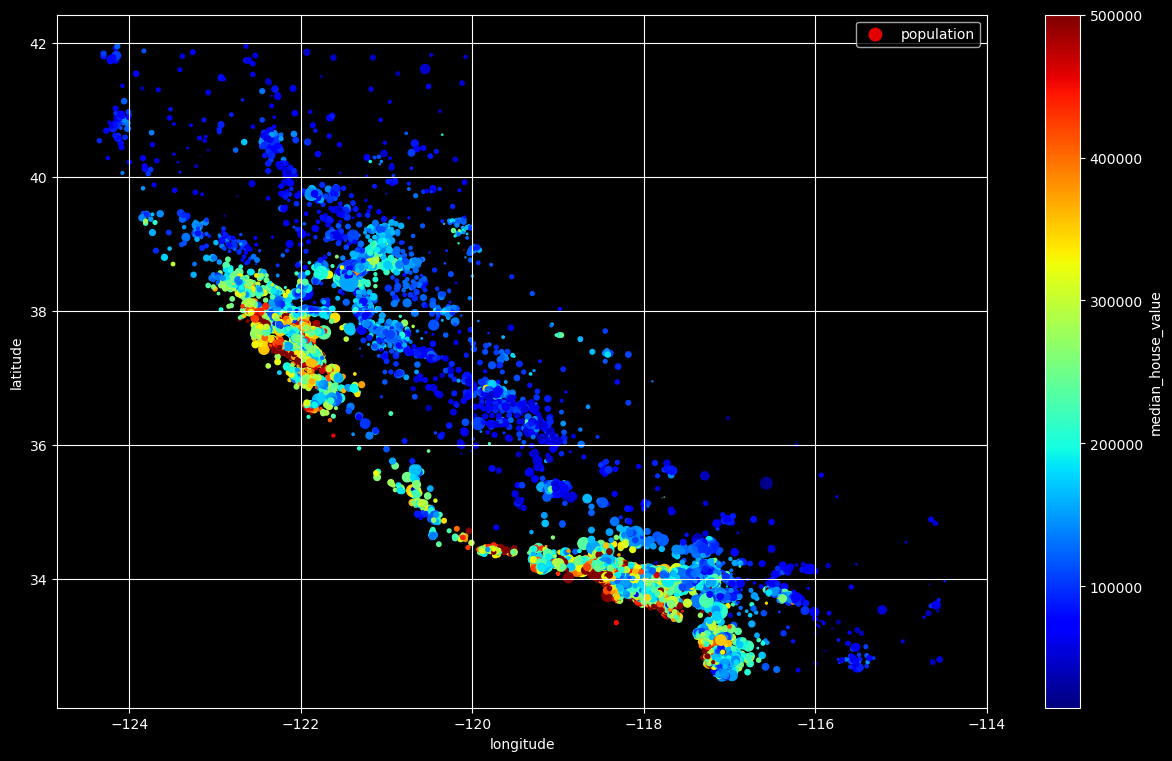

In [13]:
# this is a scatter plot of the latatude and longitude of the districts
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"] / 100, label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex = False, figsize=(15, 9))

In [14]:
# this gives us pearson's r which is the standard correlation coefficient
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_22863/3745312948.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

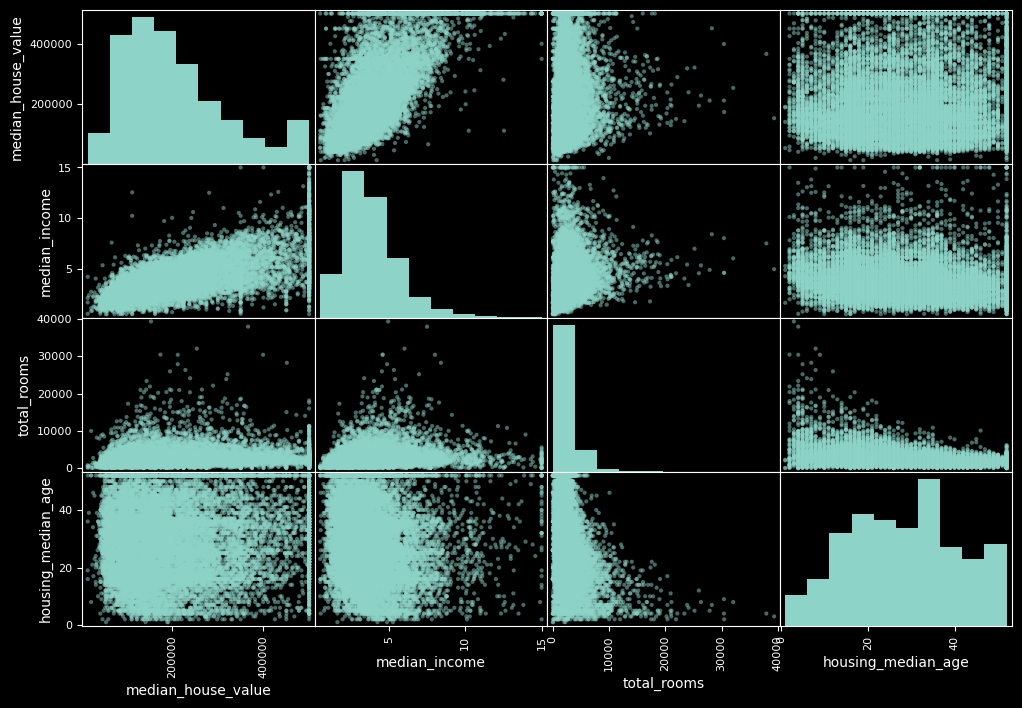

In [15]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

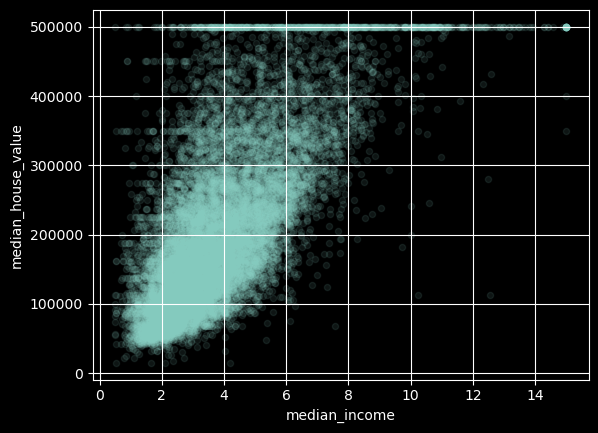

In [16]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)

In [17]:
# this will create more useful attributes for us
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [18]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_22863/826279322.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value     1.000000
median_income          0.688380
rooms_per_household    0.143663
total_rooms            0.137455
housing_median_age     0.102175
households             0.071426
total_bedrooms         0.054635
population            -0.020153
people_per_house      -0.038224
longitude             -0.050859
latitude              -0.139584
bedrooms_ratio        -0.256397
Name: median_house_value, dtype: float64

In [19]:
# drop creates a copy of the data and does not affect strat_train_set
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Cleaning the data

In [20]:
# we need to clean the data by filling in the missing values
# there are three options for this
# 1. get rid of the corresponding districts
# 2. get rid of the whole attribute
# 3. set the values to some value (zero, the mean, the median, etc.)
# housing.dropna(subset=["total_bedrooms"], inplace=True) # option 1
# housing.drop("total_bedrooms", axis=1) # option 2
# median = housing["total_bedrooms"].median() # option 3
# housing["total_bedrooms"].fillna(median, inplace=True)
#option 3 is the least disruptive to the data 

In [21]:
 # we are going to use sklearn's SimpleImputer to fill in the missing values
imputer = SimpleImputer(strategy="median")
# since the median can only be computed on the numerical attributes we need to create a copy of the data without the text attribute
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num) # this fits the imputer instance to the training data

SimpleImputer(strategy='median')

In [22]:
print(imputer.statistics_) # this gives us the median of each attribute
print(housing_num.median().values) # this is the same as above

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


In [23]:
X = imputer.transform(housing_num) # this replaces the missing values with the learned medians
# missing values can also be filled using mean or most frequent values or with a constant
# KNNImputer replaces missing values with the mean of the k nearest neighbors
# IterativeImputer replaces missing values by modeling each feature with missing values as a function of other features

# scikit learn transformers output numpy arrays even if the input is a pandas dataframe luckily we can put the output back into a dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


In [24]:
housing_cat = housing[["ocean_proximity"]]
# this gives us the catagory ocean_proximity as a number
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [25]:
# machine learning algroithms perform better when the input is a number so we need to convert the text to numbers
# we can use sklearn's OrdinalEncoder to do this
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [26]:
ordinal_encoder.categories_ # this gives us the list of categories

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [27]:
# one hot encoding is just giving dummy variables to each category so that the machine learning algorithm does not think that the categories are related
# 1 = hot, 0 = cold
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
# by default the output is a sparce matrix
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [28]:
df_test = pd.DataFrame({'ocean_proximity': ['INLAND', 'NEAR BAY']})
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [29]:
df_test_unknown = pd.DataFrame({'ocean_proximity':['<2H OCEAN', 'INLAND']})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_INLAND
0,1,0
1,0,1


In [30]:
cat_encoder.handle_unknown = 'ignore' # this will ignore unknown categories
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [31]:
# wen fitting any sci-kit learn estimator the estimator will store column names if they are available
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown), columns=cat_encoder.get_feature_names_out(), index=df_test_unknown.index)

In [32]:
# one transformation is feature scaling which is scaling the values so that they are all in the same range. algorithms do not perform well when the input numerical attributes have very different scales
# there are two ways min max scaling and standardization
# min max scaling is also called normalization and is done by subtracting the min value and dividing by the max minus the min
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [33]:
# standardization is done by subtracting the mean and dividing by the standard deviation
# standardization is less affected by outliers
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)
# if you want to scale a sparce matrix without converting it to a dense matrix you can use a standard scaler with with_mean=False

In [34]:
# this measures the similarity between housing median age and 35
age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)

In [35]:
# this scales it then transforms the predictions back to the original scale
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [36]:
# this is a simple way to do the same thing as above
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

CUSTOM TRANSFORMERS

In [37]:
# we sometimes have to make custom transformers so that we can do custom cleanup operations or combine specific attributes
# for transformations that dont require training we can just write a function that inputs a numpy array and outputs a transformed numpy array
# this is a log-transformer that applies to the population feature
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp) # the inverse function is optional 
log_pop = log_transformer.transform(housing[["population"]])

In [38]:
# this creates the same gaussian radial basis function kernel as above but as a transformer
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[['housing_median_age']])
# the RBF does not treat the features seperately. If you pass it an array with two features it will measure the 2d distance(euclidean) between the points

In [39]:
# for example this measures the geographic similarity between San Francisco and every other district in the training set
sf_choords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_choords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[['latitude', 'longitude']])
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [40]:
# all a custom class needs is fit() which returns self, transform() which returns a numpy array, and fit_transform() which returns a numpy array
# if you add BaseEstimator as a base class and avoid *args and **kargs in the constructor you will get two extra methods get_params() and set_params() that will be useful for automatic hyperparameter tuning
# this is an example of a custom transformer that acts like a standard scaler
class StandardScalerClone(BaseEstimator, TransformerMixin):
	def __init__(self, with_mean=True): # no *args and **kargs
		self.with_mean = with_mean
	
	def fit(self, X, y=None): # y is required even if we dont use it
			X = check_array(X) # checks that x is an array with finite floating point values
			self.mean_ = X.mean(axis=0) # calculates the mean of each feature
			self.scale_ = X.std(axis=0) # calculates the standard deviation of each feature
			self.n_features_in_ = X.shape[1] # stores the number of features in fit()
			return self # always return self
	def transform(self, X):
		check_is_fitted(self) # this looks for learned attributes with the suffix _ and raises a NotFittedError if they are not found
		X = check_array(X)
		assert self.n_features_in_ == X.shape[1] # checks that the number of features is the same as in fit()
		if self.with_mean:
			X = X - self.mean_
		return X / self.scale_
	
	# the sklearn.utils.validation package has lots of functions that are useful for validating inputs
	# pipelines require the fit() method to have two parameters X and y even if y is not used
	# all estimators set n_features_in_ and n_outputs_in_ in fit() and ensure that data passed to transform() has the same number of features and outputs
	# the fit() method must return self
	# all estimators should set feature_names_in_ and output_names_in_ in fit() if they are available as well as inverse_transform() if they are reversible

In [41]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [42]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [43]:
similarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

Transformation Pipelines

In [44]:
# there are many steps that need to be executed in the right order SK learn provides the pipeline class to help with this
# for example this is a small pipeline for the numerical attributes which will first impute the missing values with the median then add the combined attributes then scale them
num_pipeline = Pipeline([('impute', SimpleImputer(strategy='median')), ('standardize', StandardScaler()), ])
# the pipeline constructor takes a list of name/estimator pairs defining a sequence of steps they must all be transformers except for the last one which can be any estimator 

In [45]:
set_config(display='diagram')
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [46]:
# if you dont want to name the transformers you can use the make_pipeline() function
num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [47]:
# the pipeline exposes the same methods as the final estimator so if the last estimator is a standard scaler(which is a trasformer) the pipeline will act like a transformer
# calling it will apply all the transforms to the data in sequence
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)
# if you wnat to recover a dataframe we can use the pipelines get_feature_names_out() method
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index)
# pipelines suppor indexing you can also access the estimators via the steps attribute which is a list of name/estimator pairs

In [48]:
# the following column transformer applies the num_pipeline to the numerical attributes and the one hot encoder to the categorical attributes
num_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
cat_attribs = ['ocean_proximity']

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
	OneHotEncoder(handle_unknown='ignore'))

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

# we define two lists of column names one for the numerical attributes and one for the categorical attributes then we construct a column transformer with two pipelines one for the numerical attributes and one for the categorical attributes
# column transformer takes a list of tuples each contaning a unique name, a transformer, and a list of names of columns that the transformer should be applied to
# can use drop to drop columns or passthrough to leave them unchanged 

In [49]:
# since listing column names is not very efficent sk learn gives us the make_column_selector() function that returns a selector function that can automatically select all features of a given type
# you can pass this to the column transformer in stead of a list of names or if you dont care about names you can use make_column_transformer()
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

housing_prepared = preprocessing.fit_transform(housing)
# transformers must never modify the number of rows

Creating the full pipeline

In [50]:
# what the pipeline will do
# 1 missing values will be imputed with the median
# 2 encode the categorical attributes as one hot(dummy variables)
# 3 ratio features will be added: bedroom_ratio, rooms_per_house, and people_per_house to better correlate with the median house value
# 4 we add a few cluster similarity features which should be more useful than the latitude and longitude
# 5 long tail features will be replaced with their logarithm to create a more uniform distribution
# 6 all numerical features will be standardized to get the same scale

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age # one column remaining: housing_median_age

In [51]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(16512, 24)

In [52]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

SELECT AND TRAIN A MODEL

linear regression

In [53]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x124...
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x124e86e10>)])),
                ('linearregression', LinearRegression())])

In [54]:
housing_predictions = lin_reg.predict(housing)
print(housing_predictions[:5].round(-2))
print(housing_labels.iloc[:5].values)

[243700. 372400. 128800.  94400. 328300.]
[458300. 483800. 101700.  96100. 361800.]


In [55]:
# these predictions are close on some but far off on others we chose RMSE as our performance measure so we want to measure the RMSE on the whole training set
# we can use the mean_squared_error function from sk learn with squared=False to get the RMSE
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse
# this tells us how big our typical prediction error which is not very good we underfit the data 
# to fix underfitting we can use a more powerful model or feed the training algorithm with better features or reduce the constraints on the model
# this model is not regularized so we can rule out the last option
# we first want to try a more powerful model to see if it can handle the data better before we go back and look at the features

68687.8917659013

DECISION TREE REGRESSOR

In [56]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x124...
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x124e86e10>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [57]:
# now that the model is trained we can evaluate it on the training set
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse
# this model is overfitting so badly that it performs worse than the linear regression model we can use cross validation to verify this

0.0

In [58]:
# to evaluate we use sklearn's k-fold cross valuation feature it randomly splits the training set into 10 distinct subsets called folds then it trains and evaluates the decision tree model 10 times picking a different fold for evaluation every time and training on the other 9 folds the result is an array containing the 10 evaluation scores
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
# sk learn's cross validation features expect a utility function greater is better so the scoring function is actually the opposite of the MSE which is why the preceding code computes -scores before calculating the square root
pd.Series(tree_rmses).describe()

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

In [59]:
# the decision tree performs just as bad a linear regression model or worse
# the cross validation allows us to get not only an estimate of the performance of the model but also a measure of how precise this estimate is using sd
# we know that there is overfitting because the score on the training set is much higher than on the validation sets

Random Forest Regressor

In [60]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

In [61]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47019.561281
std       1033.957120
min      45458.112527
25%      46464.031184
50%      46967.596354
75%      47325.694987
max      49243.765795
dtype: float64

In [62]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


17474.619286483998

In [63]:
# because the training RMSE is still much lower than the validation RMSE the model is still overfitting the training set 
# we can fine tune the model by searching for the hyperparameters that minimize the validation error
# we can use grid search to do this
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42))
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters':[10, 15],
     'random_forest__max_features': [6, 8, 10]}
]
grid_search = GridSearchCV(
    full_pipeline, 
    param_grid, 
    cv=3,
    scoring='neg_root_mean_squared_error')

grid_search.fit(housing, housing_labels)

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x124e86e10>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [64]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [65]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,4.147381,0.006484,0.121461,0.000171,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43459.598047,-43918.632694,-44747.781772,-44042.004171,533.085183,1
13,5.251338,0.018867,0.122066,0.000715,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-44132.027207,-44075.251239,-45009.672809,-44405.650418,427.736807,2
14,6.371616,0.017859,0.121942,0.000442,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-44374.325167,-44285.549219,-45316.375999,-44658.750128,466.421934,3
7,4.261652,0.079986,0.139862,0.010655,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44683.355320,-44654.825561,-45657.384730,-44998.521871,466.031964,4
9,4.093616,0.019337,0.122782,0.002269,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44683.355320,-44654.825561,-45657.384730,-44998.521871,466.031964,4


In [ ]:
# we can see that the best hyperparameters give us a better score than the default hyperparameters but it is still overfitting the training set and not performing the best